In [62]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

In [95]:
#読み込み
import_data_pd = pickle.load(open("import_data_pd_max.sav","rb"))

In [96]:
import_data_list = import_data_pd["text"].values.tolist()

In [97]:
#読み込み
sentence_list = pickle.load(open("sentence_list_proper_noun_ippan_dic.sav","rb"))

In [98]:
docs = np.array(sentence_list)
docs.shape

(9692,)

In [99]:
X = pd.DataFrame(docs)
Y = import_data_pd["category_od"]

In [100]:
N_train = int(len(X.index) * 0.8)
N_test = len(X.index) - N_train

In [101]:
import_data_pd['text'][0]

'一軍は大阪府をプロ野球地域保護権保護地域とし、大阪市西区大阪市西区にある大阪ドーム現：京セラドーム大阪を、大阪近鉄バファローズファーム二軍ウエスタン・リーグ所属はかつて一軍の本拠地だった藤井寺球場を本拠地にしていた。球団愛称の正式表記は「バファローズ」であり、「バッファローズ」ではない経緯に関しては#球団愛称後述。1999年3月末までの球団名は近鉄バファローズで、地域密着を謳うために1999年4月1日付で上記球団名に改称された後も通称として使われていた。なお、運営法人の商号は株式会社大阪バファローズ、近畿日本鉄道株式会社の100%の連結対象子会社額面500円だった。2004年、球団と近鉄グループの経営難からオリックス・ブルーウェーブの運営会社「オリックス野球クラブ」に営業譲渡し、大阪バファローズは2005年3月末をもって解散。職員の大半はオリックス野球クラブに、一部は楽天野球団に移り、選手は分配ドラフトによりオリックス・バファローズブルーウェーブから改称と同時に新規参入した東北楽天ゴールデンイーグルスに配分された。オリックスの球団史において大阪近鉄バファローズは傍系扱いとなるため、チームタイトルや個人賞などの各種記録については一切含まれない。このような、球団史が引き継がれずに終焉する形でのチーム消滅は1958年の大映ユニオンズ以来の出来事となる。合併までの経緯・詳細についてはプロ野球再編問題2004年を参照。1944年6月から1947年5月まで南海電気鉄道南海鉄道と大阪電気軌道関西急行鉄道の戦時統合によって設立された近畿日本鉄道が運営していた福岡ソフトバンクホークス近畿日本軍→近畿グレートリングとの球団の系譜としてのつながりはなく、これは現在の福岡ソフトバンクホークスの系譜である。球団が消滅した2004年時点で現存していた12球団の中では、4回出場した日本選手権シリーズ日本シリーズで優勝していない唯一の球団であった。'

In [102]:
expected_value = 0
expected_value_new = 0

vectorizer = TfidfVectorizer(use_idf=True, token_pattern=u'(?u)\\b\\w+\\b')

drop_columns_list = []

In [103]:
#前処理
#tfidf

In [104]:
expected_value = 0
expected_value_new = 0

vectorizer = TfidfVectorizer(use_idf=True, token_pattern=u'(?u)\\b\\w+\\b')

drop_columns_list = []


while expected_value <= expected_value_new:
    expected_value = expected_value_new
    
    print(1)
    
    #シャッフルして分割
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=N_test,shuffle = True)
    
    #学習データをベクトル化
    docs_train = np.reshape(X_train.values,(len(X_train.index)))
    docs_train_vec = vectorizer.fit_transform(docs_train)
    
    X_train_vec = pd.DataFrame(docs_train_vec.toarray())
    X_train_vec.columns = vectorizer.get_feature_names()
    
    #不要なカラムを削除
    contain_list = list(set(drop_columns_list) & set(X_train_vec.columns))
    X_train_vec = X_train_vec.drop(contain_list,axis=1)
    
    #モデル作成
    clf = RandomForestClassifier(n_estimators=400)
    
    clf.fit(X_train_vec, Y_train)
    
    #特徴量
    features = X_train_vec.columns
    importances = clf.feature_importances_
    indices = np.argsort(importances)
    
    #テストデータをベクトル化
    docs_test = np.reshape(X_test.values,(len(X_test.index)))
    docs_test_vec = vectorizer.transform(docs_test)
    
    X_test_vec = pd.DataFrame(docs_test_vec.toarray())
    X_test_vec.columns = vectorizer.get_feature_names()
    
    #不要なカラムを削除
    X_test_vec = X_test_vec.drop(contain_list,axis=1)
    
    #精度
    accuracy = clf.score(X_test_vec, Y_test)
    
    #確率
    probability =  clf.predict_proba(X_test_vec)
    
    #スコア
    score = 0
    failed_list = []
    Y_test_list = list(Y_test)
    for i in range(len(probability)):
        rabel = Y_test_list[i]
        if np.where(probability[i]==np.sort(probability[i])[-1])[0][0] == rabel:
            score += 1
        elif np.where(probability[i]==np.sort(probability[i])[-2])[0][0] == rabel:
            score += 0.5
        elif np.where(probability[i]==np.sort(probability[i])[-3])[0][0] == rabel:
            score += 0.25
        else:
            failed_list.append(X_test.index[i])
    
    #期待値
    expected_value_new = score/len(probability)
    
    print("accuracy:" + str(accuracy) + " score:" + str(score) + " expected_value:" + str(expected_value_new))
    
    drop_columns_list.extend(features[importances[indices] == 0].values)
    drop_columns_list = list(set(drop_columns_list))
print('end')

1
accuracy:0.5977307890665291 score:1336.0 expected_value:0.6890149561629706
1
accuracy:0.6142341413099536 score:1362.5 expected_value:0.7026817947395565
1
accuracy:0.6028880866425993 score:1336.25 expected_value:0.6891438886023724
end


In [30]:
failed_list

[5645,
 9247,
 5203,
 4097,
 6252,
 5277,
 6827,
 3897,
 5267,
 70,
 4080,
 3902,
 2881,
 238,
 9471,
 6187,
 4588,
 6557,
 7489,
 5428,
 8731,
 1818,
 6616,
 5111,
 4781,
 8019,
 8211,
 8896,
 9598,
 7933,
 2393,
 7556,
 2268,
 6074,
 989,
 8130,
 8443,
 7352,
 3189,
 1789,
 5856,
 9383,
 8518,
 4873,
 3290,
 3216,
 7485,
 2219,
 3286,
 1177,
 3385,
 6006,
 7176,
 4808,
 5708,
 6082,
 7571,
 9651,
 3790,
 9423,
 4997,
 4516,
 7479,
 4099,
 3994,
 9459,
 6348,
 8632,
 7858,
 8461,
 7585,
 3320,
 7910,
 4069,
 646,
 3217,
 5131,
 2314,
 1289,
 6671,
 7810,
 9530,
 3067,
 2055,
 3978,
 1679,
 8069,
 915,
 4101,
 8819,
 3196,
 6544,
 4006,
 1932,
 2018,
 6091,
 637,
 3369,
 9688,
 8229,
 8873,
 86,
 3447,
 4962,
 1926,
 7974,
 6758,
 1662,
 7257,
 770,
 3862,
 3293,
 4017,
 5384,
 4970,
 351,
 5118,
 4766,
 8168,
 1163,
 2556,
 2632,
 4399,
 5245,
 9488,
 2305,
 6676,
 3582,
 9346,
 7370,
 1984,
 77,
 3198,
 8603,
 166,
 9068,
 4971,
 7021,
 5053,
 1294,
 8970,
 9552,
 7500,
 9338,
 2597,

In [48]:
import_data_pd.iloc[[failed_list[0]]]

category                                               text company  \
5645      6050  大阪市中央区大阪市中央区の卸売卸売業が集まる船場大阪市船場地域に本社を置いている。大阪市中央...      萬栄   

      category_od  
5645           25

In [53]:
X.iloc[[5645]].values[0]

array(['大阪 中央 大阪 中央 船場 大阪 船場 地域 本社 大阪 中央 大阪 中央 南久宝寺 衣料 用品 家庭 用品 大阪 基盤 企業 メイン バンク メイン バンク 第一勧業銀行 みずほ 銀行 船場 本社 箕面 支社 みずほ 銀行 店舗 現金 自動 預け 払い atm'],
      dtype=object)

In [ ]:
#各カテゴリの文章中にある出現頻度の高い単語(卸、倉庫etc)を洗い出す
#辞書に登録する


#グループ企業も説明変数に追加できるのであればする

In [58]:
#特徴量確認
import matplotlib.pyplot as plt
%matplotlib inline

features = X_train.columns
importances = clf.feature_importances_
indices = np.argsort(importances)

In [59]:
from matplotlib.font_manager import FontProperties
fp = FontProperties(fname=r'c:\Windows\Fonts\meiryo.ttc')

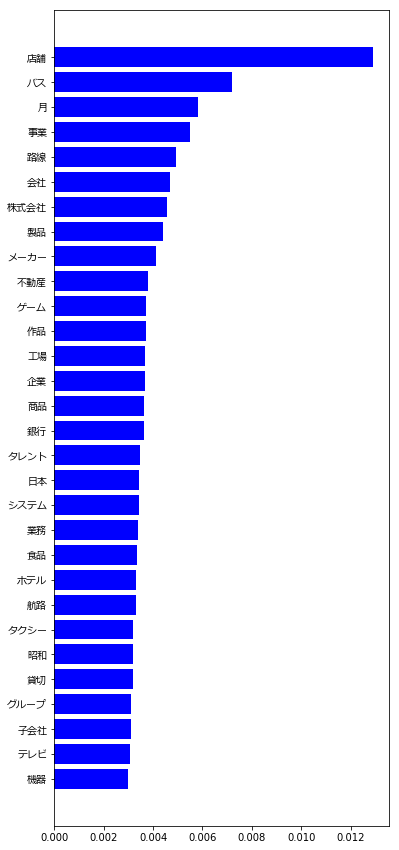

In [60]:
indices_slice = indices[-30::]

plt.figure(figsize=(6,15))
plt.barh(range(len(indices_slice)),importances[indices_slice],color="b",align="center")
plt.yticks(range(len(indices_slice)),features[indices_slice],fontproperties=fp)
plt.show()

In [109]:
X_train["category_od"] = Y_train

C:\Users\tamura\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [119]:
X_train[0].

2941    沿革 昭和 月 *資本金 *本社 所在地 東京 新宿 早稲田南 事業所 拠点 札幌 仙台 東...
1524    設立当初 大阪府 近畿 地方 中心 北海道 沖縄 日本 全国 拠点 イベントデータレコーダー...
349     バブル 郵政省 総務 民放 テレビ 全国 波 形 岩手 民放 月 局 めん 北海道 東北 地...
2208    月 モデル エージェンシー 俳優 タレント マネジメント 内田 有紀 高島 礼子 りょう タ...
8942    創業者 社長 依田 学習塾 会社 前身 設立当初 吹田 豊中 東淀川 府内 拠点 経費 拠点...
2236                             本社 岡山 都窪 早島 本店 広島 福山 南蔵王
6394    上野 耕三 農村 映画 pr 映画 おふくろ バス 文化 映画 酒井田 柿 右 衛門 柿 右...
2559    野菜 ジュース 野菜 飲料 果実 飲料 受託製造 自社ブランド 製品 長野 安曇 野市 松本...
2257    マザー ボード ビデオカードグラフィックカード 主力製品 pc ゲーミング 機器 マウスコン...
3096    東武 東上本線 東武 沿線 地域 不動産 東京 都城 北部 埼玉県 南部 物件 中心 事業 ...
5393    白髪染め ヘア カラー パオン シュワルツコフヘンケル 山発産業 洋画 佐伯 祐三 絵画 名...
4974    財団 法人 エヌケービー 公益 財団 法人 日本 交通 文化 協会 日本 交通 文化 協会 ...
1382    運営会社 株式会社 埼玉 ブロンコス トップ リーグ 日本 プロバスケットボールリーグ bj...
3270    月 リッチ 株式会社 プロミス smbc コンシューマーファイナンス 傘下 月 他社 沿革 ...
5199    昭和 月 店舗 愛知 名古屋 市内 東京 三重 福岡 大阪府 タイ 王国 ホテル 事業 会社...
1537    東芝 グループ 産業 光源 機器 ウェッジベースランプ 世界 シェア 液晶 ライト 冷 陰極...
6132    昭和 韓国 朝鮮 韓国 資本 大韓民国 韓国 韓 銀行 昭和 大阪 支店 平成 月 韓 銀行...
895     テレビ朝日 

In [116]:
X_train["category"] = import_data_pd["category"][X_train.index]

C:\Users\tamura\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [201]:
def get_rate(import_data_pd,search):
    rabel_name = "contain_" + search
    import_data_pd["all"],import_data_pd[rabel_name] = 0,0
    a_df = import_data_pd[import_data_pd["text"].str.contains(search)].groupby("category").count()
    b_df = import_data_pd.groupby("category").count()
    c_df = pd.concat([b_df["all"],a_df[rabel_name]], axis=1)
    c_df["rate"] = [c_df[rabel_name][i]/c_df["all"][i] for i in c_df.index]
    
    return c_df.fillna(0)

In [203]:
get_rate(import_data_pd,"店舗")

all  contain_店舗      rate
category                            
50          26         0.0  0.000000
1050        15         0.0  0.000000
2050       224        10.0  0.044643
3050       723        78.0  0.107884
3100        96        10.0  0.104167
3150        24         0.0  0.000000
3200       192         2.0  0.010417
3250        95         3.0  0.031579
3300        30         1.0  0.033333
3350        16         0.0  0.000000
3400        44         1.0  0.022727
3450        58         0.0  0.000000
3500        35         0.0  0.000000
3550        83         1.0  0.012048
3600       191         2.0  0.010471
3650       356         4.0  0.011236
3700       199         3.0  0.015075
3750        80         0.0  0.000000
3800       260        18.0  0.069231
4050        80         0.0  0.000000
5050       543         8.0  0.014733
5100       121         1.0  0.008264
5150        48         0.0  0.000000
5200        35         0.0  0.000000
5250      1682        16.0  0.009512
6050       337        41.0  0.121662
6100      1285       792.0  0.616342
7050       204        81.0  0.397059
7100        89        19.0  0.213483
7150        63         2.0  0.031746
7200       194        13.0  0.067010
8050       285        40.0  0.140351
9050      1979       235.0  0.118747